In [6]:
import pandas as pd
import cluj_tools as ct

from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database

from secrets import *

### Get Rosters

In [8]:
matchup_end_date, matchupPeriod = ct.matchup_end_date()

Matchup end date is 2020-02-09
Matchup period is 16


In [9]:
rosters = ct.get_rosters(matchupPeriod)

In [10]:
rosters.head()

,fullName,teamId
0,Marvin Bagley III,4
1,Kristaps Porzingis,4
2,Pascal Siakam,4
3,Lonzo Ball,4
4,Joel Embiid,4


### Get Boxscore data to calculate octys

In [11]:
dbname = 'cluj'
engine = create_engine('postgres://%s:%s@localhost/%s'%(AUTH['db_user'],AUTH['db_pass'],dbname))

if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))

True


In [12]:
sql = """
    SELECT * FROM boxscores b
    LEFT JOIN player_name_comparison c ON b.name = c.boxscore_name
    WHERE b.season_year = '2019-2020' AND b.season_type = 'regular'
"""

In [13]:
boxscores = pd.read_sql(sql, engine)
boxscores['ft_pct'] = boxscores.ftm / boxscores.fta
boxscores['fg_pct'] = boxscores.fgm / boxscores.fga

In [14]:
boxscores.loc[boxscores.espn_name.isnull(),'espn_name'] = boxscores.loc[boxscores.espn_name.isnull(),'name']

In [15]:
ft_pct_threshold = 0.75
fg_pct_threshold = 0.4
octys = boxscores.loc[(boxscores.assists > 0) & (boxscores.threes > 0) & (boxscores.steals > 0) & (boxscores.rebounds > 0) & (boxscores['blocks'] > 0) & (boxscores.ft_pct > ft_pct_threshold) & (boxscores.fg_pct > fg_pct_threshold)]
octys.shape

(410, 21)

In [32]:
octy_counts = pd.DataFrame(octys.espn_name.value_counts())
octy_counts.reset_index(inplace=True)
octy_counts.rename(columns={'espn_name':'octy_count', 'index':'espn_name'}, inplace=True)

In [33]:
octy_counts.head()

,espn_name,octy_count
0,Anthony Davis,14
1,James Harden,11
2,Kawhi Leonard,9
3,Brandon Ingram,8
4,Joel Embiid,8


In [34]:
octys_games = pd.DataFrame(boxscores.groupby('espn_name')['assists'].count())
octys_games.reset_index(inplace=True)
octys_games.rename(columns={'assists':'game_count'}, inplace=True)

In [36]:
merged = octy_counts.merge(octys_games, on='espn_name')
merged['octy_pct'] = merged.octy_count / merged.game_count
merged.sort_values('octy_pct', ascending=False, inplace=True)
merged.shape

(177, 4)

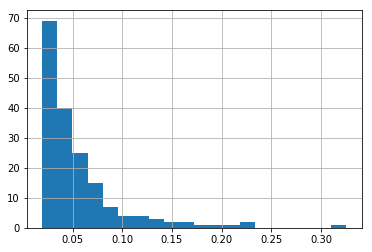

In [19]:
merged.octy_pct.hist(bins=20)

In [21]:
merged.head(30)

,espn_name,octy_count,game_count,octy_pct
0,Anthony Davis,14,43,0.325581
2,Kawhi Leonard,9,39,0.230769
1,James Harden,11,49,0.224490
4,Joel Embiid,8,37,0.216216
20,Kyrie Irving,4,20,0.200000
17,John Collins,5,27,0.185185
6,Pascal Siakam,7,41,0.170732
3,Brandon Ingram,8,47,0.170213
9,Josh Richardson,6,39,0.153846
7,Jayson Tatum,7,47,0.148936


In [37]:
rosters_merge = merged.merge(rosters, left_on='espn_name', right_on='fullName', how='left')
rosters_merge.shape

(177, 6)

In [39]:
rosters_merge.groupby('teamId')['octy_pct'].mean().sort_values()

teamId
1.0     0.041567
12.0    0.051272
2.0     0.054696
9.0     0.056361
11.0    0.057966
3.0     0.060117
6.0     0.066162
10.0    0.069635
8.0     0.072280
7.0     0.078961
5.0     0.079361
4.0     0.105404
Name: octy_pct, dtype: float64

In [40]:
rosters_merge.groupby('teamId')['octy_count'].sum()

teamId
1.0     18
2.0     18
3.0     27
4.0     44
5.0     35
6.0     26
7.0     31
8.0     24
9.0     24
10.0    35
11.0    24
12.0    17
Name: octy_count, dtype: int64

In [40]:
rosters_merge.loc[rosters_merge.teamId == 6]

,espn_name,octy_count,game_count,octy_pct,fullName,teamId
17,Kevin Love,5,45,0.111111,Kevin Love,6.0
18,LeBron James,5,48,0.104167,LeBron James,6.0
32,Davis Bertans,3,41,0.073171,Davis Bertans,6.0
38,Russell Westbrook,3,43,0.069767,Russell Westbrook,6.0
52,Jaren Jackson Jr.,3,50,0.060000,Jaren Jackson Jr.,6.0
60,Damion Lee,2,36,0.055556,Damion Lee,6.0
64,Michael Porter Jr.,2,39,0.051282,Michael Porter Jr.,6.0
66,Marcus Smart,2,40,0.050000,Marcus Smart,6.0
158,Joe Harris,1,49,0.020408,Joe Harris,6.0


In [42]:
# should only be players on waiver wire
rosters_merge.loc[rosters_merge.fullName.isnull()].sort_values('octy_pct', ascending=False).head(15)

,espn_name,octy_count,game_count,octy_pct,fullName,teamId
19,Kadeem Allen,1,10,0.100000,NaN,NaN
22,Jonathan Isaac,3,32,0.093750,NaN,NaN
23,Justise Winslow,1,11,0.090909,NaN,NaN
27,PJ Dozier,1,12,0.083333,NaN,NaN
29,Mikal Bridges,4,52,0.076923,NaN,NaN
43,Jabari Parker,2,32,0.062500,NaN,NaN
44,Josh Okogie,3,48,0.062500,NaN,NaN
46,Alec Burks,3,48,0.062500,NaN,NaN
61,Derrick Jones Jr,2,37,0.054054,NaN,NaN
64,Cameron Johnson,2,39,0.051282,NaN,NaN
